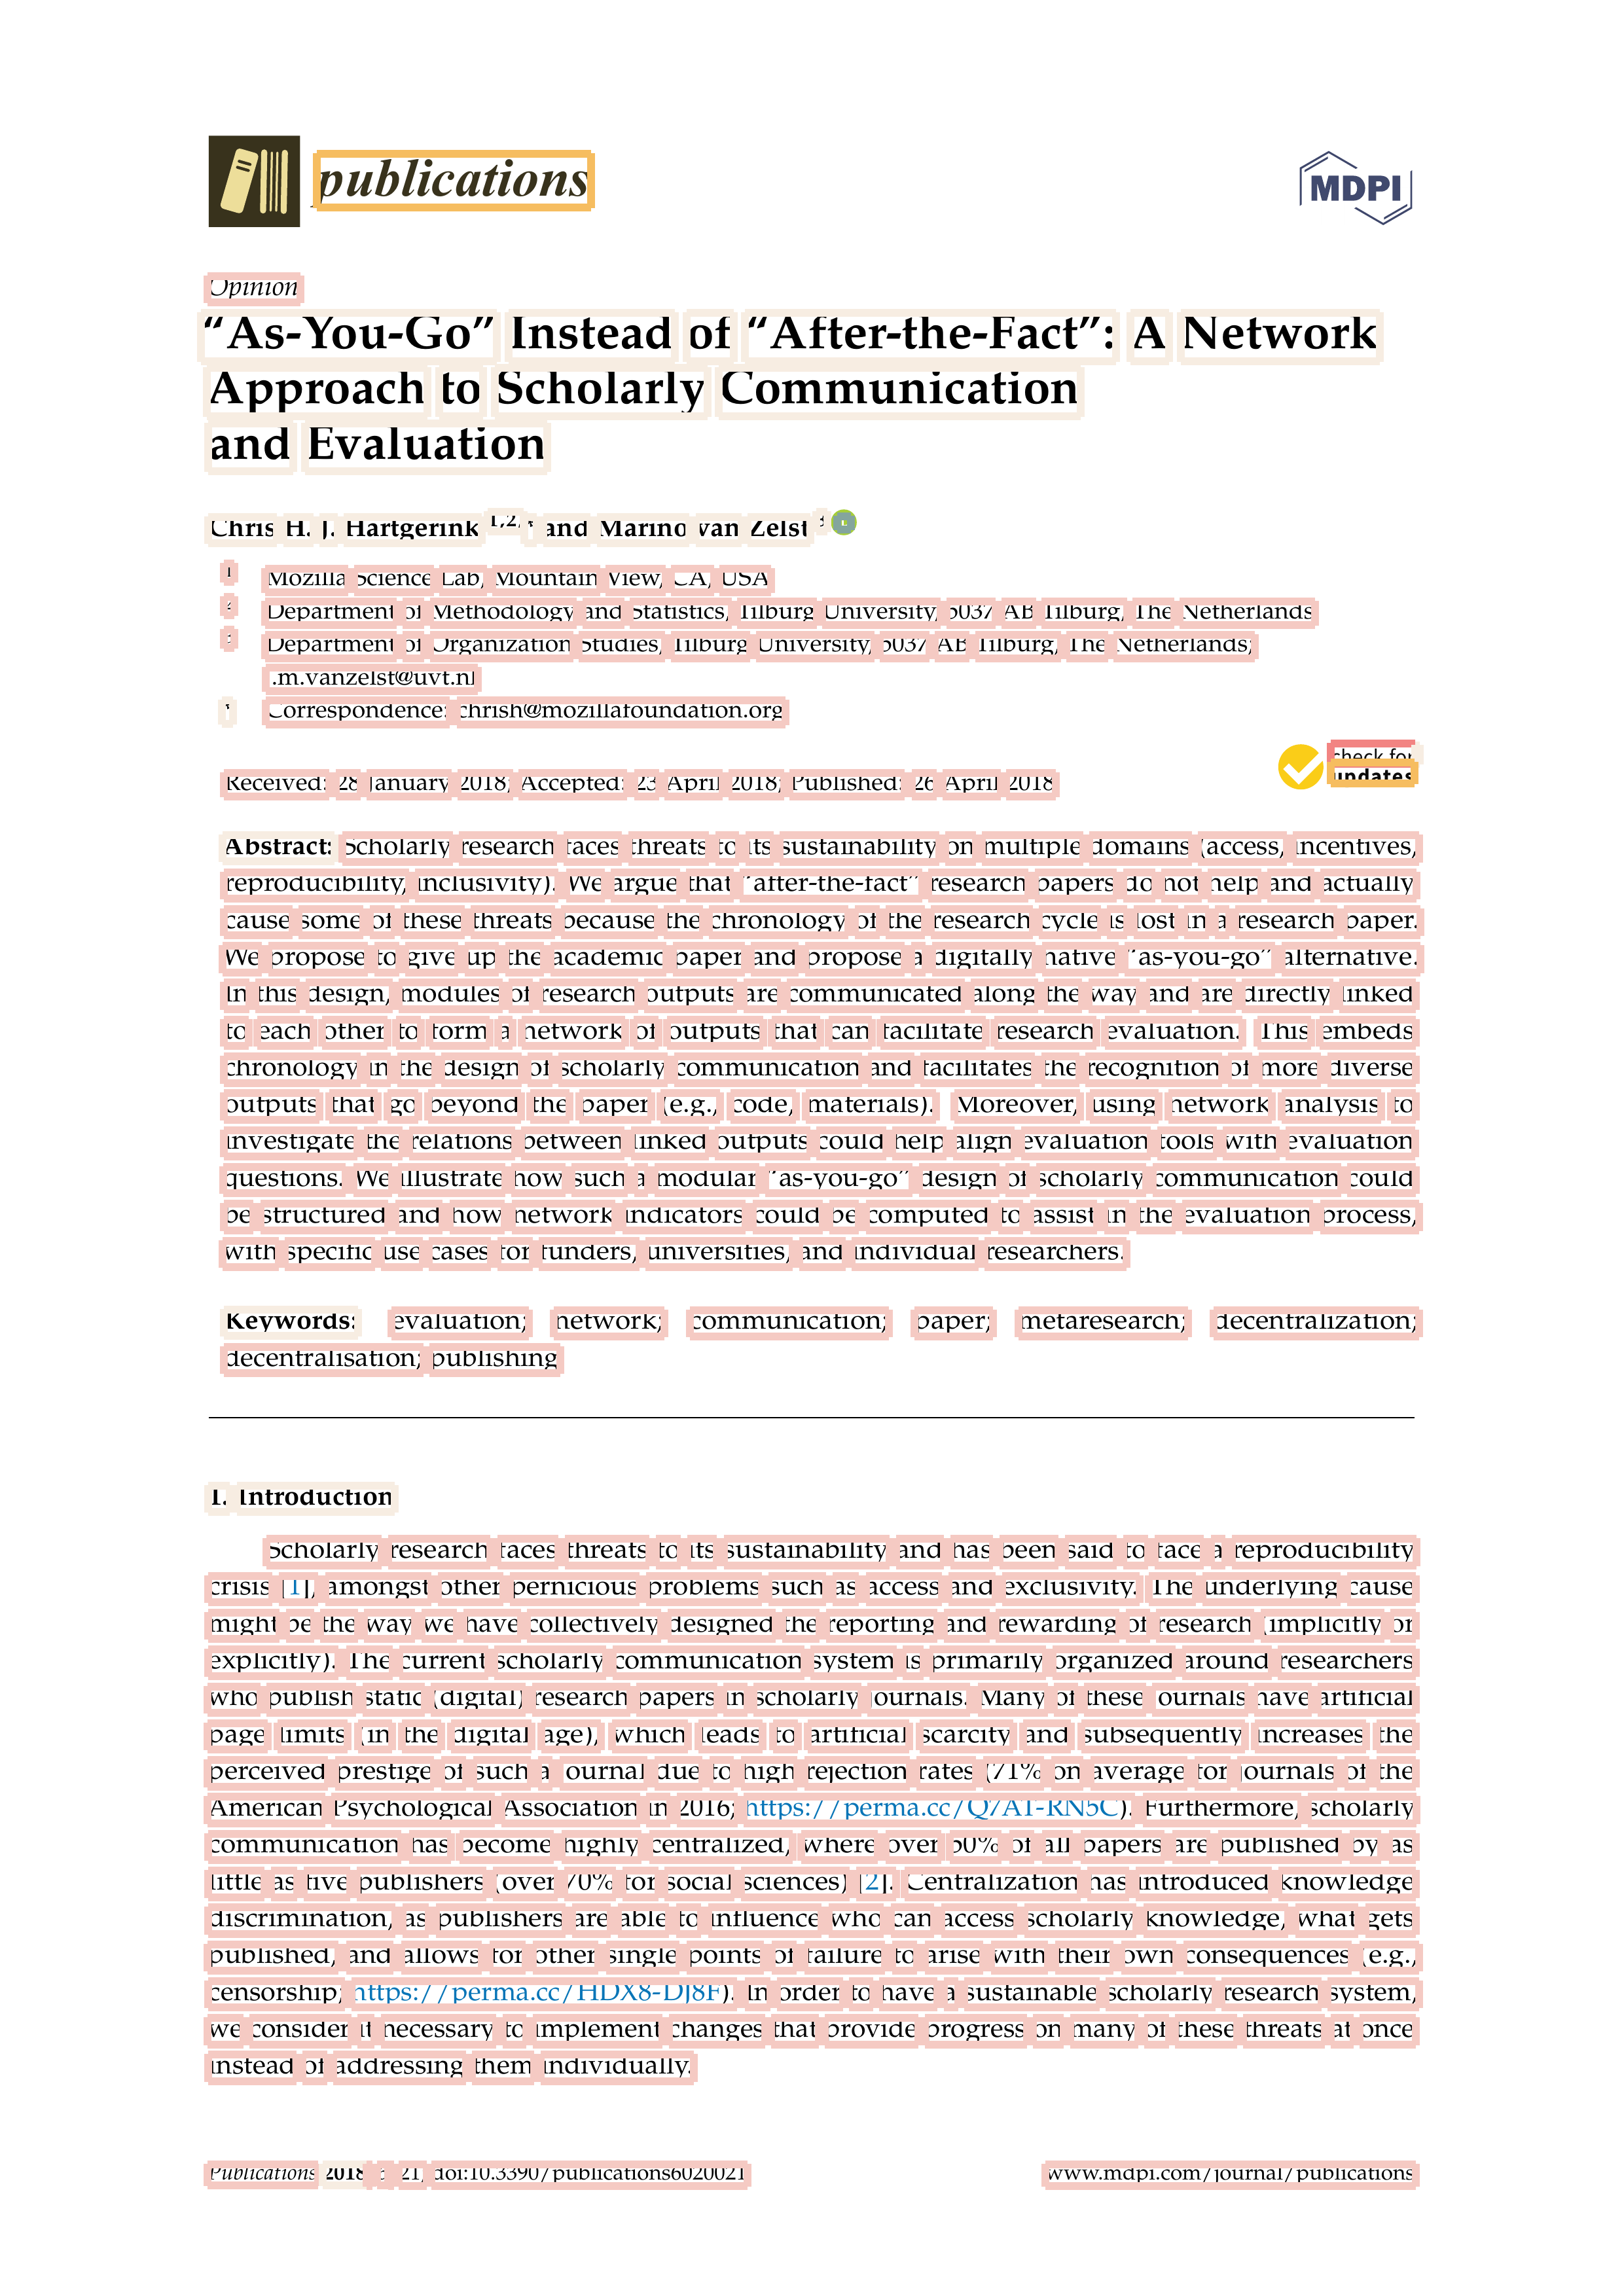

In [278]:
import layoutparser as lp
import re
import numpy as np
import subprocess

pdf_layout, pdf_images = lp.load_pdf("test-article.pdf", load_images=True, dpi=300)

lp.draw_box(pdf_images[0], pdf_layout[0])

In [279]:
# See model zoo:
# https://layout-parser.readthedocs.io/en/latest/notes/modelzoo.html
model = lp.AutoLayoutModel("lp://detectron2/PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x",
                           label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"},
                           extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8]) # Optional
image_layout = model.detect(pdf_images[0]) 


The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
/Users/nami/opt/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/detectron2/structures/image_list.py:99: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


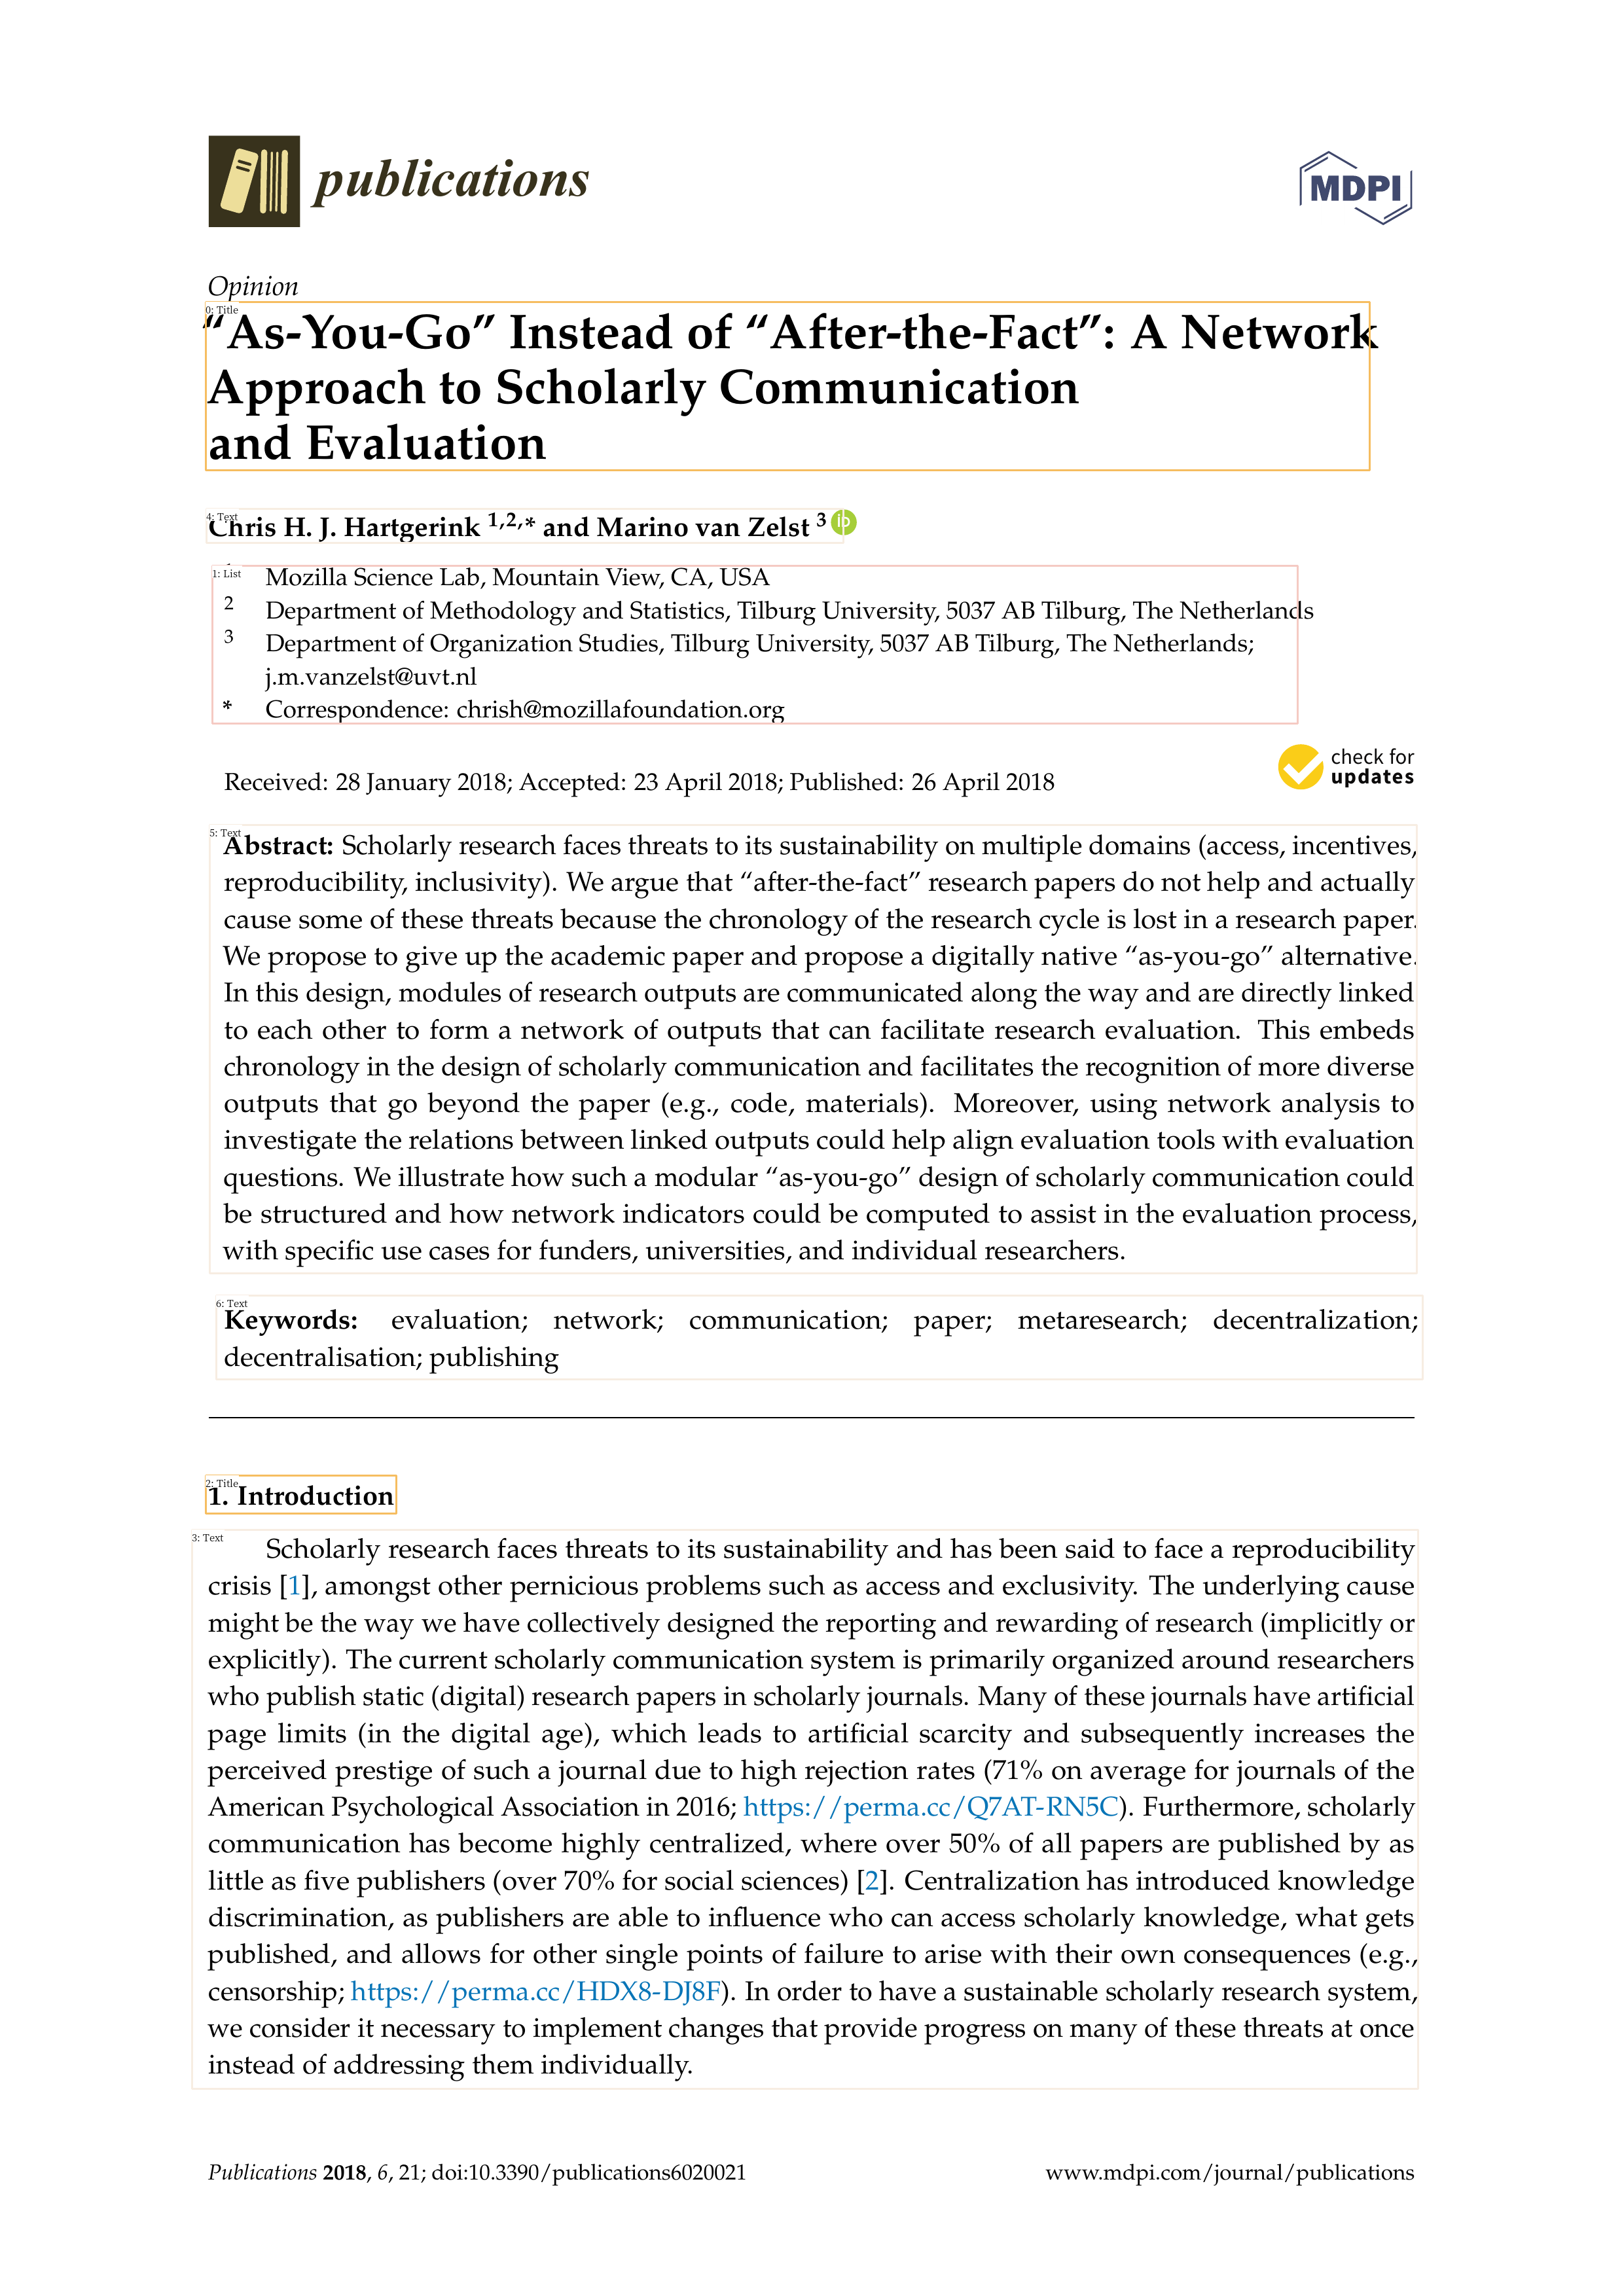

In [280]:
lp.draw_box(pdf_images[0], image_layout, box_width=3, show_element_type=True, show_element_id=True)

In [281]:
layout_sorted_by_y = sorted(image_layout, key=lambda element:element.points[0][1])

In [282]:
text_blocks = lp.Layout([b for b in layout_sorted_by_y if (b.type=='Text') & (b.score > .90)])

In [283]:
figure_blocks = lp.Layout([b for b in layout_sorted_by_y if b.type=='Figure'])

# Drop texts in figures
text_blocks_without_figures = lp.Layout([b for b in text_blocks \
                                        if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

# Sort the text according to their x-y positions


In [284]:
image_layout[0].relative_to(image_layout[1])

TextBlock(block=Rectangle(x_1=-10.1661376953125, y_1=-402.484130859375, x_2=1767.5509948730469, y_2=-145.301513671875), text=None, id=None, type=Title, parent=None, next=None, score=0.9994425177574158)

[257.1826171875,
 51.44219970703125,
 241.4912109375,
 685.3489990234375,
 127.6678466796875,
 57.049560546875,
 853.210205078125]

In [285]:
ocr_agent = lp.TesseractAgent(languages='eng')
for block in text_blocks_without_figures:
    segment_image = (block
                       .pad(left=5, right=5, top=1, bottom=1)
                       .crop_image(np.asarray(pdf_images[0])))

    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

In [286]:
text_blocks

Layout(_blocks=[TextBlock(block=Rectangle(x_1=315.7795104980469, y_1=777.6641845703125, x_2=1288.607177734375, y_2=829.1063842773438), text=Chris H. J. Hartgerink 12-* and Marino van Zelst 3 ©
, id=None, type=Text, parent=None, next=None, score=0.9606067538261414), TextBlock(block=Rectangle(x_1=320.6138610839844, y_1=1260.2303466796875, x_2=2164.876220703125, y_2=1945.579345703125), text=Abstract: Scholarly research faces threats to its sustainability on multiple domains (access, incentives,
reproducibility, inclusivity). We argue that “after-the-fact” research papers do not help and actually
cause some of these threats because the chronology of the research cycle is lost in a research paper.
We propose to give up the academic paper and propose a digitally native “as-you-go” alternative.
In this design, modules of research outputs are communicated along the way and are directly linked
to each other to form a network of outputs that can facilitate research evaluation. This embeds
chrono

In [315]:
# drop textbox if the box is super sumall
box_heights = [b.height for b in text_blocks]
avg_box_height = sum(box_heights) / len(box_heights)
min_box_height = avg_box_height - 1 * np.std(box_heights)

# Drop the small box
text_blocks = lp.Layout([b for b in text_blocks if b.height >= min_box_height])

In [316]:
text_container = []

for txt in text_blocks.get_texts():
    text = re.sub(r"(@\[A-Za-z0-9]+)|\[.+\]", "", txt) 
    # convert one linebreak to a space but not two
    text = re.sub(r'\r?\n(?!\r?\n)', ' ', text)

    # convert e.g., to for example
    # text = re.sub(r'e.g.,', "for example,", text)

    # Convert % to "percent"
    text = re.sub(r'\%', " percent", text)

    # Remove parenthesis text 
    text = re.sub(r'\(([^)]+)\)', "", text)

    # Remove the space before periods and comma
    text = re.sub(r'\s+(?=\.|\,)', "", text)

    print(text, end='\n---\n')
    text_container.append(text)


Abstract: Scholarly research faces threats to its sustainability on multiple domains . We argue that “after-the-fact” research papers do not help and actually cause some of these threats because the chronology of the research cycle is lost in a research paper. We propose to give up the academic paper and propose a digitally native “as-you-go” alternative. In this design, modules of research outputs are communicated along the way and are directly linked to each other to form a network of outputs that can facilitate research evaluation. This embeds chronology in the design of scholarly communication and facilitates the recognition of more diverse outputs that go beyond the paper . Moreover, using network analysis to investigate the relations between linked outputs could help align evaluation tools with evaluation questions. We illustrate how such a modular “as-you-go” design of scholarly communication could be structured and how network indicators could be computed to assist in the evalu

In [317]:
text_container

['Abstract: Scholarly research faces threats to its sustainability on multiple domains . We argue that “after-the-fact” research papers do not help and actually cause some of these threats because the chronology of the research cycle is lost in a research paper. We propose to give up the academic paper and propose a digitally native “as-you-go” alternative. In this design, modules of research outputs are communicated along the way and are directly linked to each other to form a network of outputs that can facilitate research evaluation. This embeds chronology in the design of scholarly communication and facilitates the recognition of more diverse outputs that go beyond the paper . Moreover, using network analysis to investigate the relations between linked outputs could help align evaluation tools with evaluation questions. We illustrate how such a modular “as-you-go” design of scholarly communication could be structured and how network indicators could be computed to assist in the eva

In [334]:
# https://colab.research.google.com/drive/1iAe7ZdxjUIuN6V4ooaCt0fACEGKEn7HW?usp=sharing#scrollTo=FuHUxvHDf8sX
import subprocess
import shlex

# print(shlex.quote(text_container[0]))

bashCommand = "tts --text "

for idx, paragraph in enumerate(text_container):

    text_to_tts = shlex.quote(" ".join(paragraph))

    split_commands = bashCommand.split()

    split_commands = split_commands + [paragraph] + ["--out_path", "./paragraph-%s.wav" % idx + 1]

    print(split_commands)

    process = subprocess.Popen(split_commands, stdout=subprocess.PIPE)
    output, error = process.communicate()

    print(output)

#   > Decoder stopped with `max_decoder_steps` 500
# Change file .venv/lib/python3.8/site-packages/TTS/tts/configs/
# https://github.com/mozilla/TTS/issues/734

# /Users/nami/opt/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/TTS/tts/configs/tacotron_config.py
# Changed max_decoder_steps to 1000

['tts', '--text', 'Abstract: Scholarly research faces threats to its sustainability on multiple domains. We argue that “after-the-fact” research papers do not help and actually cause some of these threats because the chronology of the research cycle is lost in a research paper. We propose to give up the academic paper and propose a digitally native “as-you-go” alternative. In this design, modules of research outputs are communicated along the way and are directly linked to each other to form a network of outputs that can facilitate research evaluation. This embeds chronology in the design of scholarly communication and facilitates the recognition of more diverse outputs that go beyond the paper. Moreover, using network analysis to investigate the relations between linked outputs could help align evaluation tools with evaluation questions. We illustrate how such a modular “as-you-go” design of scholarly communication could be structured and how network indicators could be computed to as